**Neural Chef Assistance**  
**Name: Darren Jer Shien Yee**  
**Student ID: 31237223**

**Implementation of Baseline 1: RNN without Attention**

In [1]:
## Requirements
!pip3 install nltk
!pip3 install tensorboardX
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


**Implementation of Baseline 1: Language Method imported from RNN code provided in tutorials**

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
        self.unique_words = []

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.unique_words.append(word)
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**Implementation of Baseline 1: Unicode and ASCII method to preprocess data**

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase only (since numerical is crucial here as opposed to lab code)
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace('\t', ' ')
    return s

**Implementation of Baseline 1: Method to read data from provided CSV**

In [4]:
import pandas as pd

def readLangs(reverse=False):
    # Read the CSV file
    train_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/train.csv')
    valid_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/dev.csv')
    test_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/test.csv')
    
    train_df.fillna('', inplace=True)
    valid_df.fillna('', inplace=True)
    test_df.fillna('', inplace=True)
    
    train_ingredients = train_df['Ingredients']
    train_recipes = train_df['Recipe']
    valid_ingredients = valid_df['Ingredients']
    valid_recipes = valid_df['Recipe']    
    test_ingredients = test_df['Ingredients']
    test_recipes = test_df['Recipe']
    
    train_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(train_ingredients, train_recipes)]
    valid_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(valid_ingredients, valid_recipes)]
    test_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(test_ingredients, test_recipes)]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('Recipe')
        output_lang = Lang('Ingredients')
    else:
        input_lang = Lang('Ingredients')
        output_lang = Lang('Recipe')
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

**Implementation of Baseline 1: Preprocess data and intialise language using the methods above**

In [5]:
MAX_LENGTH = 150
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read %s sentence pairs" % len(train_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs = filterPairs(test_pairs)
    print("Trimmed to %s sentence pairs" % len(train_pairs))
    print("Counting words...")
    for pair in train_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

input_lang, output_lang, train_pairs, valid_pairs, test_pairs = prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read 101340 sentence pairs
Trimmed to 79894 sentence pairs
Counting words...
Counted words:
Ingredients 37056
Recipe 35620
['2 lg tomatoes, peeled and -seeded and chopped chopped.                           1 ts ground cumin 4    tomatillos, husked and 1 ts fresh lime juice chopped.                           1 ts sugar 2    fresh anaheim chiles, seeded 1 ts minced fresh cilantro and chopped.                     1/2 ts freshly ground black pepper 5    green onions, chopped. -(one half, not 1 to 2!) 2    fresh jalapeno pepper, 1/4 ts salt.', 'in lidded jar , combine all ingredients and marinate for at least one hour .']


**Implementation of Baseline 1: Encoder RNN for seq2seq model without attention**

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Implementation of Baseline 1: Decoder RNN for seq2seq model without attention**

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 1: Processing methods for train iter**

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

**Implementation of Baseline 1: Train method for seq2seq model without attention**

In [9]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [10]:
def valid(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**Implementation of Baseline 1: Time method for train iter method** 

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

**Implementation of Baseline 1: Train iter method**

In [12]:
def trainIters(encoder, decoder, n_iters,train_pairs,valid_pairs, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_train_losses = []
    plot_valid_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_valid_loss_total = 0  # Reset every print_every
    plot_valid_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    valid_pairs = [tensorsFromPair(random.choice(valid_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        training_input_tensor = training_pair[0]
        training_target_tensor = training_pair[1]

        valid_pair = valid_pairs[iter - 1]
        valid_input_tensor = valid_pair[0]
        valid_target_tensor = valid_pair[1]

        train_loss = train(training_input_tensor, training_target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        valid_loss = valid(valid_input_tensor, valid_target_tensor, encoder,
             decoder, criterion)
        print_valid_loss_total += valid_loss
        plot_valid_loss_total += valid_loss

        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_valid_loss_avg = print_valid_loss_total / print_every
            print_valid_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                             iter, iter / n_iters * 100,
                                                                             print_train_loss_avg, print_valid_loss_avg))
        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_valid_loss_avg = plot_valid_loss_total / plot_every
            plot_valid_losses.append(plot_valid_loss_avg)
            plot_valid_loss_total = 0
    return plot_train_losses,plot_valid_losses


**Implementation of Baseline 1: Show Plot method**

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
def showPlot(model_name,points1, points2, epochs, plot_every):
    plt.figure()
    fig, ax = plt.subplots()
    # This locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    x_range = np.array(np.arange(0, epochs-1, plot_every))
    plt.plot(x_range,points1, label='Train')  # Plot points1 with label 'Train'
    plt.plot(x_range,points2, label='Valid')  # Plot points2 with label 'Valid'
    plt.legend()  # Add legend
    plt.xlabel('Epochs')  # Label x-axis
    plt.ylabel('Loss')  # Label y-axis
    plt.title(model_name+' Training and Validation Loss')  # Set title for the plot
    plt.show()

**Implementation of Baseline 1: Evaluation methods to check performance of baseline 1**

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [15]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

**Implementation of Baseline 1: Creating instance of baseline 1 and training**

In [16]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 1000
baseline1_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
baseline1_decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
baseline1_plot_train_losses,baseline1_plot_valid_losses = trainIters(baseline1_encoder, baseline1_decoder, n_iter ,train_pairs,valid_pairs, print_every = print_every,plot_every=plot_every)

3m 43s (- 33m 27s) (1000 10%) Train Loss: 5.2575 | Validation Loss: 5.8910
7m 31s (- 30m 4s) (2000 20%) Train Loss: 4.2646 | Validation Loss: 7.4216
11m 8s (- 25m 59s) (3000 30%) Train Loss: 4.0323 | Validation Loss: 7.0332
14m 48s (- 22m 13s) (4000 40%) Train Loss: 3.8705 | Validation Loss: 7.1795
18m 28s (- 18m 28s) (5000 50%) Train Loss: 3.7074 | Validation Loss: 7.1183
22m 6s (- 14m 44s) (6000 60%) Train Loss: 3.6632 | Validation Loss: 6.8458
25m 49s (- 11m 4s) (7000 70%) Train Loss: 3.6219 | Validation Loss: 6.8262
29m 26s (- 7m 21s) (8000 80%) Train Loss: 3.4981 | Validation Loss: 6.6977
33m 6s (- 3m 40s) (9000 90%) Train Loss: 3.5256 | Validation Loss: 7.0627
36m 37s (- 0m 0s) (10000 100%) Train Loss: 3.4865 | Validation Loss: 6.7179


<Figure size 640x480 with 0 Axes>

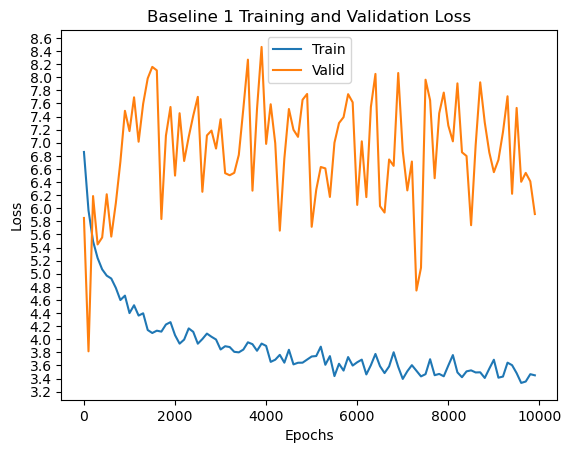

In [17]:
showPlot('Baseline 1',baseline1_plot_train_losses,baseline1_plot_valid_losses,n_iter,plot_every)

**Implementation of Baseline 2: RNN with Attention**

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        #self.out = nn.Linear(self.hidden_size, self.output_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        attn_weights = F.softmax(torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)

        # attn_weights = F.softmax(
        #     self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # attn_applied = torch.bmm(attn_weights.unsqueeze(0),
        #                          encoder_outputs.unsqueeze(0))

        # output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output = self.attn_combine(output).unsqueeze(0)

        # output = F.relu(output)
        # output, hidden = self.gru(output, hidden)

        # output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 2: Train method for RNN with attention**

In [40]:
teacher_forcing_ratio = 1.0


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [20]:
teacher_forcing_ratio = 1.0
def valid_attn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**Implementation of Baseline 2: Train iter method for RNN with attention**

In [21]:
def trainIters_attn(encoder, decoder, n_iters,print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_train_losses = []
    plot_valid_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_valid_loss_total = 0  # Reset every print_every
    plot_valid_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(valid_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        training_input_tensor = training_pair[0]
        training_target_tensor = training_pair[1]

        valid_pair = validation_pairs[iter - 1]
        valid_input_tensor = valid_pair[0]
        valid_target_tensor = valid_pair[1]

        train_loss = train_attn(training_input_tensor, training_target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        valid_loss = valid_attn(valid_input_tensor, valid_target_tensor, encoder,
             decoder, criterion)
        print_valid_loss_total += valid_loss
        plot_valid_loss_total += valid_loss

        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_valid_loss_avg = print_valid_loss_total / print_every
            print_valid_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                             iter, iter / n_iters * 100,
                                                                             print_train_loss_avg, print_valid_loss_avg))
        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_valid_loss_avg = plot_valid_loss_total / plot_every
            plot_valid_losses.append(plot_valid_loss_avg)
            plot_valid_loss_total = 0
    return plot_train_losses,plot_valid_losses


**Implementation of Baseline 2: Initialising instance of RNN with attention**

In [22]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
baseline2_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
baseline2_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_train_losses,plot_valid_losses = trainIters_attn(baseline2_encoder, baseline2_decoder, 10000, print_every=1000)

4m 59s (- 44m 51s) (1000 10%) Train Loss: 5.0167 | Validation Loss: 5.7930
10m 0s (- 40m 2s) (2000 20%) Train Loss: 4.1381 | Validation Loss: 7.4241
14m 55s (- 34m 49s) (3000 30%) Train Loss: 3.9509 | Validation Loss: 7.1153
19m 53s (- 29m 49s) (4000 40%) Train Loss: 3.7651 | Validation Loss: 6.9461
24m 43s (- 24m 43s) (5000 50%) Train Loss: 3.7191 | Validation Loss: 6.3911
29m 33s (- 19m 42s) (6000 60%) Train Loss: 3.7379 | Validation Loss: 6.6121
34m 31s (- 14m 47s) (7000 70%) Train Loss: 3.5848 | Validation Loss: 6.7975
39m 21s (- 9m 50s) (8000 80%) Train Loss: 3.5992 | Validation Loss: 6.8467
44m 4s (- 4m 53s) (9000 90%) Train Loss: 3.5189 | Validation Loss: 6.7071
48m 45s (- 0m 0s) (10000 100%) Train Loss: 3.4914 | Validation Loss: 6.4984


**Implementation of Baseline 2: Evaluation method for RNN with Attention**

In [23]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [24]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [255]:
# evaluateRandomly_attn(baseline2_encoder, baseline2_decoder)

**Extension 1: Data Preprocessing**

In [ ]:
# SOS_token = 0
# EOS_token = 1
# UNK_token = 2 

# class Lang:
#     def __init__(self, name, max_vocab_size = 300):
#         self.name = name
#         self.word2index = {}
#         self.word2count = {}
#         self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}  # Include UNK token
#         self.n_words = 3  # Count SOS, EOS, and UNK
#         self.unique_words = []
#         self.max_vocab_size = max_vocab_size

#     def addSentence(self, sentence):
#         for word in sentence.split(' '):
#             self.addWord(word)

#     def addWord(self, word):
#         if word not in self.word2index:
#             self.unique_words.append(word)
#             self.word2index[word] = self.n_words
#             self.word2count[word] = 1
#             self.index2word[self.n_words] = word
#             self.n_words += 1
#         else:
#             self.word2count[word] += 1

#     def trimVocab(self):
#             # Sort words based on their counts in descending order
#             sorted_words = sorted(self.word2count.items(), key=lambda x: x[1], reverse=True)
#             # Select top max_vocab_size words
#             top_words = [word for word, count in sorted_words[:self.max_vocab_size]]
            
#             # Replace less frequent words with UNK token
#             for word in self.unique_words:
#                 if word not in top_words:
#                     self.word2index[word] = UNK_token
#             self.n_words = len(set(self.word2index.values()))


In [27]:
MAX_LENGTH = 150
import re
def clean_text(text):
    # Define regular expression pattern to match numeric values and units
    amount_pattern = r'\b[\d.]+(?:\s*(?:g|kg|l|ml|tsp|tbsp|cup|pint|quart|oz|c|tb|ts|b|ea|pk|t|can|cups|cn|ounce)\b)?'
    # Remove numeric values and units from the text
    text = re.sub(amount_pattern, '', text)

    # Remove irrelevant information like advertisements, website navigation elements, etc.
    # Assuming such information may be enclosed within angle brackets or parentheses
    bracket_pattern = r'<[^>]*>|(\([^)]*\))'
    remove_words = r'-rrb-|-lrb-|medium|small|large|chopped|sliced|softened|or|and|lb'
    # Remove text inside angle brackets and parentheses
    cleaned_text = re.sub(bracket_pattern, '', text)
    cleaned_text = re.sub(remove_words, '', cleaned_text)

    # Handle missing data and standardize text format
    cleaned_text = cleaned_text.lower()  # Convert text to lowercase
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # Remove punctuation
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra whitespaces
    return cleaned_text

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read %s sentence pairs" % len(train_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs = filterPairs(test_pairs)
    print("Trimmed to %s sentence pairs" % len(train_pairs))
    print("Counting words...")
    for pair in train_pairs:
        pair[0] = clean_text(pair[0])
        pair[1] = clean_text(pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        pair[0] = clean_text(pair[0])
        pair[1] = clean_text(pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        pair[0] = clean_text(pair[0])
        pair[1] = clean_text(pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

input_lang, output_lang, train_pairs, valid_pairs, test_pairs = prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read 101340 sentence pairs
Trimmed to 79894 sentence pairs
Counting words...
Counted words:
Ingredients 17277
Recipe 30770
['butter margarine dry mustard allpurpose flour shredded sharp milk cheddar cheese salt', 'melt butter in a quart glass measuring pitcher in microwave oven about seconds at high add flour blend to a smooth paste add milk gradually stirring constantly cook uncovered in microwave overn minutes at high until thickened stir vigously after minutes then every seconds add salt dry mustard cheese to sauce stir well cook uncovered in microwave oven minute at high stir adventures in microwave cooking']


In [28]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
extension1_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
extension1_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_extension1_train_losses,plot_extension1_valid_losses = trainIters_attn(extension1_encoder, extension1_decoder, 10000, print_every=1000)

3m 6s (- 27m 58s) (1000 10%) Train Loss: 5.6433 | Validation Loss: 7.1666
6m 5s (- 24m 22s) (2000 20%) Train Loss: 4.8312 | Validation Loss: 7.0344
9m 2s (- 21m 5s) (3000 30%) Train Loss: 4.5183 | Validation Loss: 6.6910
11m 57s (- 17m 55s) (4000 40%) Train Loss: 4.3713 | Validation Loss: 6.9389
14m 55s (- 14m 55s) (5000 50%) Train Loss: 4.3046 | Validation Loss: 6.6119
17m 48s (- 11m 52s) (6000 60%) Train Loss: 4.2013 | Validation Loss: 6.3562
20m 47s (- 8m 54s) (7000 70%) Train Loss: 4.1882 | Validation Loss: 6.9355
23m 41s (- 5m 55s) (8000 80%) Train Loss: 4.0764 | Validation Loss: 6.3158
26m 33s (- 2m 57s) (9000 90%) Train Loss: 4.1135 | Validation Loss: 6.6523
29m 27s (- 0m 0s) (10000 100%) Train Loss: 4.0802 | Validation Loss: 6.3868


<Figure size 640x480 with 0 Axes>

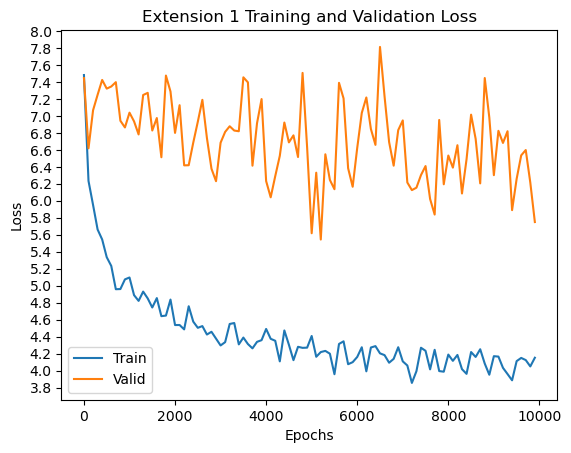

In [29]:
showPlot('Extension 1',plot_extension1_train_losses,plot_extension1_valid_losses,n_iter,plot_every)

In [601]:
evaluateRandomly_attn(extension1_encoder, extension1_decoder)

> lean ground beef med onion carrots sliced celery sliced cabbage sliced tomato paste worcestershire sauce beef bouillon or stock
= in skillet brown hamburger adn drain thoroughly add onion carrots celery and cabbage combine tomato paste worcestershire sauce and beef stockbouillon add to crock pot with hamburger an stir to blend cover and cook on low setting for to hours or high setting for to hours


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [31]:
class EncoderRNN_Layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


**Extension 2: Stacking Layers**

In [32]:
class AttnDecoderRNN_Layers(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers, dropout_p=0.1, max_length=200):
        super(AttnDecoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        attn_weights = F.softmax(torch.bmm(hidden[-1].unsqueeze(0), encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [33]:
hidden_size = 128
n_iter = 10000
plot_every = 100
print_every = 100
extension2_encoder = EncoderRNN_Layers(input_lang.n_words, hidden_size, num_layers=2).to(device)
extension2_decoder = AttnDecoderRNN_Layers(hidden_size, output_lang.n_words, num_layers=2, dropout_p=0.2).to(device)
plot_extension2_train_losses,plot_extension2_valid_losses = trainIters_attn(extension2_encoder, extension2_decoder, 10000, print_every=1000)

2m 18s (- 20m 43s) (1000 10%) Train Loss: 5.9193 | Validation Loss: 6.8734
4m 37s (- 18m 28s) (2000 20%) Train Loss: 4.9875 | Validation Loss: 6.3525
7m 1s (- 16m 24s) (3000 30%) Train Loss: 4.7500 | Validation Loss: 6.7843
9m 24s (- 14m 6s) (4000 40%) Train Loss: 4.6192 | Validation Loss: 6.8996
11m 42s (- 11m 42s) (5000 50%) Train Loss: 4.4792 | Validation Loss: 6.8797
14m 5s (- 9m 23s) (6000 60%) Train Loss: 4.4341 | Validation Loss: 6.9790
16m 23s (- 7m 1s) (7000 70%) Train Loss: 4.3710 | Validation Loss: 7.3125
18m 36s (- 4m 39s) (8000 80%) Train Loss: 4.2607 | Validation Loss: 6.7645
20m 53s (- 2m 19s) (9000 90%) Train Loss: 4.2454 | Validation Loss: 6.8450
23m 5s (- 0m 0s) (10000 100%) Train Loss: 4.2372 | Validation Loss: 6.9971


In [253]:
# evaluateRandomly_attn(extension2_encoder, extension2_decoder)

In [35]:
def evaluateRandomly_attn_test(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [252]:
# evaluateRandomly_attn_test(extension2_encoder, extension2_decoder)

**Paper implementation: NN Swap baseline model implementation**

In [495]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors

def fit_nearest_neighbor(train_pair, max_length=MAX_LENGTH):
    # Precompute padded pairs and norms for all recipes in the dataset
    padded_pairs = []
    norms = []
    for pair in train_pair:
        # Convert sentence to tensor
        current_pair = tensorFromSentence(input_lang, pair[0])
        # Pad tensor
        padding_length = max(0, max_length - len(current_pair))
        padded_pair = torch.cat((current_pair.squeeze(), torch.zeros(padding_length, dtype=torch.long).to(device)))
        # Append to list
        padded_pairs.append(padded_pair)
    
    # Convert list of tensors to a single tensor
    padded_pairs_tensor = torch.stack(padded_pairs)
    
    # Fit NearestNeighbors model
    nn_model = NearestNeighbors(metric='cosine')
    nn_model.fit(padded_pairs_tensor.cpu().numpy())  # Convert tensor to numpy array
    return nn_model
nn_model = fit_nearest_neighbor(train_pairs)


In [510]:
test = tensorFromSentence(input_lang, test_pairs[10][0])
print(test_pairs[10][0])
# Pad test tensor
padding_length = max(0, MAX_LENGTH - len(test))
test_padded = torch.cat((test.squeeze(), torch.zeros(padding_length, dtype=torch.long).to(device)))
pred = nn_model.kneighbors([test_padded.cpu().numpy()], n_neighbors=4, return_distance=False)[0]
print(train_pairs[pred[1]][0])
print(train_pairs[pred[1]][1])

olive oil dried thyme sm onion dried marjoram stalks celery beef stock garlic clove minced bay leaf bulgur parsley dried rubbed sage salt and pepper to taste
paprika salt onion powder ground black pepper cayenne salt black pepper chili powder ketchup white vinegar water yellow onion diced sorghum molasses
mix in jar cover and shake well to mix sprinkle rub liberally over and into the surface prepare smoker for long slow cooking using hickory mesquite is also very good combine all ingredients in a saucepan bring to a gentle simmer allow to cool for at least one hour to allow the flavors to blend


In [313]:
MAX_LENGTH = 150
import re
def clean_text(text):
    # Define regular expression pattern to match numeric values and units
    amount_pattern = r'\b[\d.]+(?:\s*(?:g|kg|l|ml|tsp|tbsp|cup|pint|quart|oz|c|tb|ts|b|ea|pk|t|can|cups|cn|ounce)\b)?'
    # Remove numeric values and units from the text
    text = re.sub(amount_pattern, '', text)

    # Remove irrelevant information like advertisements, website navigation elements, etc.
    # Assuming such information may be enclosed within angle brackets or parentheses
    bracket_pattern = r'<[^>]*>|(\([^)]*\))'
    remove_words = r'-rrb-|-lrb-'
    # Define the words to filter out
    words_to_filter = ['medium', 'large', 'small','chopped','lb','finely','thinly','desired']
    
    # Create a regex pattern to match the specified words surrounded by spaces
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_filter) + r')\b'

    # Remove text inside angle brackets and parentheses
    cleaned_text = re.sub(bracket_pattern, '', text)
    cleaned_text = re.sub(remove_words, '', cleaned_text)
    cleaned_text = re.sub(pattern, '', cleaned_text)

    # Handle missing data and standardize text format
    cleaned_text = cleaned_text.lower()  # Convert text to lowercase
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # Remove punctuation
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra whitespaces
    return cleaned_text

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read %s sentence pairs" % len(train_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs = filterPairs(test_pairs)
    print("Trimmed to %s sentence pairs" % len(train_pairs))
    print("Counting words...")
    for pair in train_pairs:
        pair[0] = clean_text(pair[0])
        pair[1] = clean_text(pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        pair[0] = clean_text(pair[0])
        pair[1] = clean_text(pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        pair[0] = clean_text(pair[0])
        pair[1] = clean_text(pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

input_lang, output_lang, train_pairs, valid_pairs, test_pairs = prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read 101340 sentence pairs
Trimmed to 79894 sentence pairs
Counting words...
Counted words:
Ingredients 17570
Recipe 31182
['pills crescent dinner roll cranberry cracker crumbs grated orange peel ginger', 'unroll dough separate into triangles combine remaining ingredients spread evenly over each triangle roll place and bake crescents as directed on package label']


In [384]:
# Recipe stopwords that commonly appear that do not represent any ingredients (used to preprocess it)
# This list was generated by ChatGPT3.5
recipe_stopwords = [
    'preheat', 'oven', 'bake', 'baking', 'baked', 'bakes',
    'minutes', 'hour', 'hours', 'minutes', 'second', 'seconds',
    'degrees', 'celsius', 'fahrenheit',
    'medium', 'low', 'high', 'heat','cold', 'stir', 'simmer', 'boil', 'cook', 'grill',
    'whisk', 'mix', 'combine', 'fold', 'blend', 'puree', 'chop', 'dice', 'slice',
    'peel', 'mince', 'drizzle', 'sprinkle', 'garnish', 'marinate', 'brush',
    'refrigerate', 'chill', 'cool', 'freeze', 'thaw', 'room', 'temperature',
    'bowl', 'plate', 'pan', 'pot', 'skillet', 'saucepan', 'baking', 'dish',
    'tray', 'oven', 'sheet', 'foil', 'parchment', 'paper', 'whisk', 'spatula',
    'spoon', 'knife', 'cutting', 'board', 'tongs', 'fork', 'mixer', 'blender',
    'food', 'processor', 'grater', 'peeler', 'sifter', 'rolling', 'pin', 'oven', 
    'mitts', 'rack', 'cooling', 'wire', 'timer', 'timer', 'recipe', 'directions', 
    'ingredients', 'instructions', 'method', 'step', 'steps', 'serve', 'serving', 
    'makes', 'yield', 'yield:', 'yields', 'size', 'number', 'portion', 'portions', 
    'note', 'notes', 'tip', 'tips', 'variations', 'version', 'versions', 'credit', 
    'credits', 'source', 'sources', 'adapted', 'adaptation', 'adaptations', 'based', 
    'courtesy', 'original', 'author', 'authors', 'website', 'link', 'links', 'video', 
    'videos', 'facebook', 'instagram', 'twitter', 'pinterest', 'youtube', 'email', 
    'subscribe', 'rss', 'save', 'print', 'rate', 'comment', 'share', 'subscribe', 
    'like', 'love', 'follow', 'pin', 'pinning', 'tweet', 'email', 'yum', 'instagram', 
    'snapchat', 'facebook', 'twitter', 'pinterest', 'linkedin', 'reddit', 'tumblr', 
    'whatsapp', 'telegram', 'messenger', 'sms', 'message', 'chat', 'print', 'kitchen', 
    'tip', 'tips', 'trick', 'tricks', 'hack', 'hacks', 'kitchen', 'kitchens', 'home', 
    'homes', 'family', 'families', 'friend', 'friends', 'guest', 'guests', 'love', 
    'lover', 'lovers', 'party', 'parties', 'holiday', 'holidays', 'season', 'seasons', 
    'occasion', 'occasions', 'day', 'days', 'night', 'nights', 'morning', 'mornings', 
    'afternoon', 'afternoons', 'evening', 'evenings', 'week', 'weeks', 'month', 'months', 
    'year', 'years', 'today', 'tomorrow', 'yesterday', 'fresh', 'from', 'the', 'store', 
    'grocery', 'groceries', 'shop', 'shopping', 'shopping', 'list', 'lists', 'order', 
    'orders', 'online', 'offline', 'local', 'farm', 'market', 'markets', 'buy', 'purchase', 
    'sell', 'sold', 'sold', 'out', 'brand', 'brands', 'company', 'companies', 'product', 
    'products', 'item', 'items', 'stock', 'store', 'stores', 'store', 'cupboard', 'pantry', 
    'cabinet', 'cabinets', 'shelf', 'shelves', 'freezer', 'fridge', 'refrigerator', 'appliance', 
    'appliances', 'equipment', 'accessory', 'accessories', 'tool', 'tools', 'utensil', 'utensils', 
    'gadget', 'gadgets', 'ingredient', 'ingredients', 'shop', 'shopping', 'store', 'supermarket', 
    'grocery', 'groceries', 'product', 'products', 'item', 'items', 'market', 'markets', 'local', 
    'online', 'organic', 'fresh', 'best', 'quality', 'brand', 'brands', 'company', 'companies', 
    'sale', 'discount', 'offer', 'deal', 'special', 'new', 'hot', 'trend', 'trending', 'popular', 
    'favorite', 'essential', 'basic', 'must', 'need', 'want', 'buy', 'purchase', 'sell', 'sold', 
    'stock', 'top', 'high', 'low', 'price', 'cost', 'cheap', 'expensive', 'affordable', 'budget', 
    'value', 'range', 'selection', 'variety', 'choice', 'option', 'flavor', 'flavors', 'taste', 
    'tastes', 'texture', 'textures', 'aroma', 'aromas', 'color', 'colors', 'colour', 'colours', 
    'style', 'styles', 'type', 'types', 'kind', 'kinds', 'size', 'sizes', 'amount', 'portion', 
    'portions', 'quantity', 'measure', 'measures', 'weight', 'volume', 'piece', 'pieces', 'bit', 
    'bits', 'part', 'parts', 'whole', 'half', 'quarter', 'third', 'eighth', 'sixteenth', 'tablespoon', 
    'tablespoons', 'teaspoon', 'teaspoons', 'cup', 'cups', 'pint', 'pints', 'quart', 'quarts', 
    'gallon', 'gallons', 'ounce', 'ounces', 'pound', 'pounds', 'gram', 'grams', 'kilogram', 
    'kilograms', 'liter', 'liters', 'milliliter', 'milliliters', 'inch', 'inches', 'foot', 
    'feet', 'yard', 'yards', 'meter', 'meters', 'centimeter', 'centimeters', 'kilometer', 
    'kilometers', 'mile', 'miles', 'small', 'medium', 'large', 'size', 'sized', 'big', 'bigger', 
    'biggest', 'tiny', 'tinier', 'tiniest', 'mini', 'minis', 'miniature', 'micro', 'miniature', 
    'average', 'normal', 'standard', 'fine', 'finest', 'finer', 'best', 'better', 'worst', 
    'least', 'most', 'more', 'fewer', 'few', 'lots', 'plenty', 'ton', 'tons', 'great', 'greater', 
    'greatest', 'awesome', 'fantastic', 'amazing', 'good', 'better', 'best', 'excellent', 
    'wonderful', 'remarkable', 'outstanding', 'brilliant', 'superb', 'fabulous', 'terrific', 
    'exceptional', 'phenomenal', 'splendid', 'extraordinary', 'magnificent', 'top-notch', 
    'first-rate', 'high-quality', 'premium', 'deluxe', 'luxury', 'high-end', 'superior', 
    'supreme', 'ultimate', 'divine', 'heavenly', 'fab', 'fancy', 'lux', 'lush', 'posh', 
    'swanky', 'chic', 'classy', 'elegant', 'fashionable', 'stylish', 'trendy', 'up-to-date', 
    'hip', 'cool', 'trendsetting', 'cutting-edge', 'innovative', 'forward-thinking', 
    'progressive', 'modern', 'contemporary', 'sleek', 'chic', 'tasteful', 'sophisticated', 
    'cultured', 'polished', 'refined', 'classic', 'timeless', 'nostalgic', 'vintage']

In [417]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('stopwords')

# Sample text
text = ' '.join(pair[0] for pair in train_pairs)
tokens = word_tokenize(text)
# Remove stopwords
stop_words = set(stopwords.words('english') + recipe_stopwords)
tokens = [word for word in tokens if word not in stop_words]
# Remove everything except for those that are Nouns
pos_tags = pos_tag(tokens)
tokens = [word for word, pos in pos_tags if pos == 'NN'or pos == 'NNS']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [418]:
from gensim.models import Phrases
# Create phrases
# Define phrases to be forced
force_phrases = {"seeds", "seed","syrups", "syrup", "juice", "juices","cream","creams","leaf","leaves","flavoured","flavours","cooled","cool","pieces"}
# Create phrases
irrelevant_words = {'bring_boil','smooth','food','temperature','blender','let', 'well', 'along', 'cut','least', 'hours', 'desired', 'minutes', 'allow', 'remove', 'mixed', 'serve', 'bring', 'soften', 'fold', 'stirring', 'serving', 'simmer', 'sit', 'heat', 'stir', 'remove_heat', 'combine', 'pour', 'gently', 'blend', 'puree', 'chilled', 'freeze', 'container', 'room_temperature', 'saucepan', 'mixture', 'consistency','turn','mill','trays','bowls'}
bigram = Phrases([tokens], min_count=5, threshold=3)
from gensim.models.phrases import Phraser
bigram_phraser = Phraser(bigram)
tokens_with_phrases = bigram_phraser[tokens]
token_counts = Counter(tokens_with_phrases)
# Select top k tokens by occurrences
k = 100000
unique_tokens_with_phrases = [token for token, count in token_counts.most_common(k) if token not in force_phrases and token not in irrelevant_words]


In [419]:
test_ing = clean_text('2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries')
gold_recipe = 'combine <sugar> and <water> in medium saucepan . Heat , stirring , until <sugar> dissolves , then boil 5 minutes . cool . force <strawberries> through food mill or blend in blender or food processor . strain to remove seeds , if desired . blend the puree and <lemon juice> and <orange juice> into syrup . pour into freezer trays and freeze . remove from freezer 20 minutes before serving . turn into bowl and stir until smooth .'
generated_recipe = 'Combine <sugar> and <water> in a medium saucepan . Heat, stirring, until <sugar> dissolves . Bring to a boil and let simmer for 5 minutes . Remove from heat and allow to cool . In a blender or food processor , combine <strawberries> and <cantaloupe> . Blend until smooth . Strain the mixture to remove any seeds and fibers, if desired. Stir the puree into the cooled syrup along with the <lemon juice> and <orange juice> . Pour the mixture into a large bowl and gently fold in the <vanilla ice cream> until well mixed . Freeze in a container for at least 4 hours . Before serving , let it sit at room temperature for 20 minutes to soften . Stir well to achieve a smooth consistency and serve chilled .'

def prerocess_for_count (sentence):
    sentence_tokens = word_tokenize(sentence.lower())
    return [word for word in sentence_tokens if word not in stop_words]

sentence_tokens_test = prerocess_for_count(test_ing)
sentence_tokens_gold_recipe = prerocess_for_count(gold_recipe)
sentence_tokens_generated_recipe = prerocess_for_count(generated_recipe)

matched_phrases = []
# Iterate through the sentence tokens pairwise
def count_ingredients(unique_tokens_with_phrases, sentence_tokens):
    final_phrases = []
    i = 0
    while i < len(sentence_tokens):
        phrase = '_'.join(sentence_tokens[i:i+2])
        if phrase in unique_tokens_with_phrases:
            final_phrases.append(phrase)
            i += 2
        elif sentence_tokens[i] in unique_tokens_with_phrases:
            final_phrases.append(sentence_tokens[i])
            i += 1
        else:
            phrase = '_'.join(sentence_tokens[i:i+4])
            i += 1
    return set(final_phrases)

print (count_ingredients(unique_tokens_with_phrases,sentence_tokens_test))
print(count_ingredients(unique_tokens_with_phrases,sentence_tokens_gold_recipe))
print(count_ingredients(unique_tokens_with_phrases,sentence_tokens_generated_recipe))

{'lemon_juice', 'orange_juice', 'water', 'sugar', 'strawberries'}
{'lemon_juice', 'orange_juice', 'water', 'sugar', 'strawberries'}
{'vanilla_ice', 'lemon_juice', 'orange_juice', 'water', 'sugar', 'cantaloupe', 'strawberries'}


In [533]:
def eval_test(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


In [534]:
def eval_test_atnn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


In [589]:
def check_test_set(encoder, decoder,test_pairs,attention_status,unique_tokens_with_phrases):
    start = time.time()
    test_loss_total = 0  # Reset every print_every

    testing_pairs = [tensorsFromPair(pair) for pair in test_pairs]
    criterion = nn.NLLLoss()
    avg_given = []
    avg_extra = []

    for i in range (len(testing_pairs)):
        test_pair = testing_pairs[i]
        test_input_tensor = test_pair[0]
        test_target_tensor = test_pair[1]
        if attention_status:
            test_loss = eval_test_atnn(test_input_tensor, test_target_tensor, encoder,
     decoder, criterion)
            ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
            output_words, attention= evaluate_attn(encoder, decoder, test_pairs[i][0])
            output_words=' '.join(output_words)
            used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
            ingredients_stated = max(1,len(ingredients))
            used_given = len(used_ingredients & ingredients) / ingredients_stated
            avg_given.append(used_given)
            extra_items = max(0,len(used_ingredients) - len(ingredients))
            avg_extra.append(extra_items)

        else:
            test_loss = eval_test(test_input_tensor, test_target_tensor, encoder,
             decoder, criterion)
            ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
            output_words=' '.join(evaluate(encoder, decoder, test_pairs[i][0]))
            used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
            ingredients_stated = max(1,len(ingredients))
            used_given = len(used_ingredients & ingredients) / ingredients_stated
            avg_given.append(used_given)
            extra_items = max(0,len(used_ingredients) - len(ingredients))
            avg_extra.append(extra_items)
        
        test_loss_total += test_loss
    final_loss = test_loss_total / len(testing_pairs)
    return final_loss,avg_given,avg_extra


In [590]:
final_loss,avg_given,avg_extra = check_test_set(baseline1_encoder, baseline1_decoder,test_pairs,False,unique_tokens_with_phrases)

KeyboardInterrupt: 

In [585]:
print (avg_given)

[0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.05555555555555555, 0.045454545454545456, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.038461538461538464, 0.0, 0.16666666666666666, 0.0, 0.1, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.16666666666666666, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142857142857142, 0.0, 0.0, 0.18181818181818182, 0.375, 0.0, 0.041666666666666664, 0.0, 0.0, 0.38461538461538464, 0.23076923076923078, 0.125, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.047619047619047616, 0.16666666666666666, 0.0, 0.06666666666666667, 0.3, 0.0, 0.3333333333333333, 0.0, 0.0, 0.23076923076923078, 0.045454545454545456, 0.0, 0.0, 0.058823529411764705, 0.0, 0.0625, 0.13333333333333333, 0.3333333333333333, 0.0, 0.05555555555555555, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07692307692307693, 0.

In [583]:
print (np.mean(avg_given))

0.04328700377772978


In [584]:
print (np.mean(avg_extra))

0.9141494435612083


In [598]:
final_loss,avg_given,avg_extra = check_test_set(baseline2_encoder, baseline2_decoder,test_pairs,True,unique_tokens_with_phrases)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [592]:
print (np.mean(avg_given))

0.03678667109184106


In [594]:
print (avg_given)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142857142857142, 0.14285714285714285, 0.11538461538461539, 0.2, 0.16666666666666666, 0.1111111111111111, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.08333333333333333, 0.18181818181818182, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.14285714285714285, 0.0, 0.0, 0.13636363636363635, 0.25, 0.0, 0.041666666666666664, 0.0, 0.0, 0.15384615384615385, 0.15384615384615385, 0.25, 0.0, 0.0, 0.14285714285714285, 0.1, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047619047619047616, 0.16666666666666666, 0.0, 0.06666666666666667, 0.2, 0.0, 0.2222222222222222, 0.1, 0.0, 0.23076923076923078, 0.09090909090909091, 0.05263157894736842, 0.0, 0.11764705882352941, 0.0, 0.0625, 0.13333333333333333, 0.16666666666666666, 0.0, 0.05555555555555555, 0.0, 0.06666666666666667, 0.045454545454545456, 0.0, 0.0, 0.

In [597]:
print (np.mean(avg_extra))

1.0476947535771066


In [600]:
final_loss,avg_given,avg_extra = check_test_set(extension2_encoder, extension2_decoder,test_pairs,True,unique_tokens_with_phrases)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
